### NTDS project notebook
# Amazon Electronic Products Network Analysis

`Tao Sun - Xiangzhe Meng - Süha Kagan Köse - Xingce Bao`

In [1]:
import pandas as pd
import gzip
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
pd.options.mode.chained_assignment = None

---
## Introduction

Amazon is reshaping and recording our life as the biggest online retailer and as an invisible social network. Because of our behaviors, purchasing, reviewing or just viewing, the products in Amazon are also connected together. In this project, we focus on the **Electronics** product network. 

Specfically, at first, we generate our network from three products, **Macbook, Surface and ThinkPad**, which we call "core" here. Starting from the core, we add the `also_bought` prodcuts into our network, which we call the "first layer" of our network. Then, we add the `also_bought` products of the first layer. In this project, we only add two layers of products. And, intuitively, each core is going to form one group of nodes.

The weight of edge between two products(nodes) is calculated by the number of shared `also_bought` products only or calculated by the number of shared `also_bought` products and the number of shared reviewers together.

After generating our network, we are going to use **Spectral Graph Theory**, **Transductive Learning** and **Surpervised Classification** to try to do clustering and compare the results of those methods.

The project is a combination of two spearate analysis, one is based only on Macbook and Surface and another is the study of all three groups. In each analysis, we weight our edge in two different ways and try to find out the difference. The details are shown in the index below.


---
## Index

1. [Data loading and description](#Data-loading-and-description)

2. [Data pre-processing for electronic product reviews dataset](#Data-pre-processing-for-electronic-product-reviews-dataset)

3. [Data pre-processing for electronic product metadata dataset](#Data-pre-processing-for-electronic-product-metadata-dataset)

4. [Data after pre-processing](#Data-after-pre-processing)

5. [Study on Macbook and Surface](#Study-on-Macbook-and-Surface)

    5.0 [Build two data groups](#5.0-Build-two-data-groups)

    5.1 [Use only 'also_bought'](#5.1-Use-only-the-information-of-'also_bought')
        A. Study Basic Proporities of Graph
        B. Spectral Graph Theory
        B. Transductive Learning
        
    5.2 [Use both 'also_bought' and 'reviewer'](#5.2-Use-both-the-information-of-'also_bought'-and-'reviewer')
        A. Spectral Graph Theory
        B. Surpervised Classification
        
    5.3 [Network Graphs for Mackbook and surface related products comparison](#5.3-Network-Graphs-for-Mackbook-and-surface-related-products-comparison)
    
6. [Study on Macbook, Surface and ThinkPad](#Study-on-Macbook,-Surface-and-ThinkPad)
    
    6.0 [Build three data groups](#6.0-Build-three-data-groups)
    
    6.1 [Use only 'also_bought'](#6.1-Use-only-the-information-of-'also_bought')
        A. Spectral Graph Theory
        B. Transductive Learning
        
    6.2 [Use both 'also_bought' and 'reviewer'](#6.2-Use-both-the-information-of-'also_bougtht'-and-'reviewer')
        A. Spectral Graph Theory
        B. Surpervised Classification
        
7. [Conclusion](#Conclusion)

**`Attention`**: 

Because the original data files are extremely big, we cannot upload it to the Moodle and due to that fact, it takes huge amount of time for data loading and pre-processing. If you want to execute our analysis part, you can directly **start from the part 4** where we have already generated the small pickle files of the clean and useful data. You can load it from the part 4.

---
## Data loading and description

In this project, we choose to use the subset **Electronics** of [**Amazon Product Dataset**](http://jmcauley.ucsd.edu/data/amazon/links.html), provided by Julian McAuley, UCSD. The dataset includes **product metadata** (descriptions, category information, price, brand, and image features), and links (also viewed/ also bought graphs), and millions of **reviews** (ratings, text, helpful- ness votes) spanning from May 1996 to July 2014.

The two datasets we use for the project are [**metadata of Electronics**](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Electronics.json.gz) and [**5-core review data of Electronics**](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz). 

**5-core** is the dense subset of the original review dataset and in this subset all users and items have at least 5 reviews.

### Description of our datasets
In the dataset of metadata, format is one-product-per-line in json and following attributes of products are included:

- asin - ID of the product
- title - name of the product
- price - price in US dollars (at time of crawl)
- imUrl - url of the product image
- related - related products (also bought, also viewed, bought together, buy after viewing)
- salesRank - sales rank information
- brand - brand name
- categories - list of categories the product belongs to

In the dataset of reviews, format is one-review-per-line in (loose) json. One typical review has following attributes:

- reviewerID - ID of the reviewer
- asin - ID of the product
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

### Loading the two initial datasets

- **`df_product`**: contains all the electronic products' information.
- **`df_review`**: contains all the reviews concerning the electronic products.

In [2]:
# useful functions for data loading
# which are provided by the source of the datasets

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)
        
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [3]:
# load data
df_product = getDF('data/meta_Electronics.json.gz')
df_review = getDF('data/reviews_Electronics_5.json.gz')

# generate pickle files in order to save the future laoding time
df_product.to_pickle('data/origin_product.pkl')
df_review.to_pickle('data/origin_review.pkl')

Now, let's have a look at our datasets. Below are the structures of the two dataframes:

In [4]:
df_product.head()

,asin,imUrl,description,categories,title,price,salesRank,related,brand
0,0132793040,http://ecx.images-amazon.com/images/I/31JIPhp%...,The Kelby Training DVD Mastering Blend Modes i...,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Mastering Blend Modes in A...,NaN,NaN,NaN,NaN
1,0321732944,http://ecx.images-amazon.com/images/I/31uogm6Y...,NaN,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Adobe Photoshop CS5 Crash ...,NaN,NaN,NaN,NaN
2,0439886341,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[[Electronics, Computers & Accessories, PDAs, ...",Digital Organizer and Messenger,8.15,{'Electronics': 144944},"{'also_viewed': ['0545016266', 'B009ECM8QY', '...",NaN
3,0511189877,http://ecx.images-amazon.com/images/I/41HaAhbv...,The CLIKR-5 UR5U-8780L remote control is desig...,"[[Electronics, Accessories & Supplies, Audio &...",CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,NaN,"{'also_viewed': ['B001KC08A4', 'B00KUL8O0W', '...",NaN
4,0528881469,http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN


In [5]:
df_review.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011"


---
## Data pre-processing for electronic product reviews dataset

In this part, we do some data cleaning and preprocessing works for electronic product reviews dataset. 

#### Collect all reviewers' ID for each product

We collect all the reviewer's IDs for each product and arrange them in a new dataframe shown as below.

Actually, we have chosen a **5-core structure** subset for review dataset, which means the data in which all users and items have at least 5 reviews. Therefore, for each asin, there are at least 5 related reviewer' IDs.

In [6]:
# group by asin(product ID) and save all reviewer's IDs for each asin into a list
df_product_reviewer = pd.DataFrame(df_review.groupby(['asin'])['reviewerID'].apply(list))
df_product_reviewer.to_pickle('data/product_reviewer.pkl')

In [7]:
df_product_reviewer.head()

,reviewerID
asin,
0528881469,"[AO94DHGC771SJ, AMO214LNFCEI4, A3N7T0DY83Y4IG,..."
0594451647,"[A2JXAZZI9PHK9Z, A2P5U7BDKKT7FW, AAZ084UMH8VZ2..."
0594481813,"[A7S2B0I67WNWB, A3HICVLF4PFFMN, ANSKSPEEAKY7S,..."
0972683275,"[A20XXTXWF2TCPY, A2IDCSC6NVONIZ, A1EDI0X3GI1SK..."
1400501466,"[A3LDPF5FMB782Z, A9HYSJ3D0D6I2, A3EOHF2YSVZA9L..."


In [8]:
print("There are {} electronic products who have at least 5 reviews in our dataset.".format(df_product_reviewer.shape[0]))

There are 63001 electronic products who have at least 5 reviews in our dataset.


#### Collect all reviewers' ID

In this part, we collect all the IDs of the reviewers who have commented on at least one product in our dataset.

In [9]:
reviewers = set([x for list_ in df_product_reviewer['reviewerID'].values for x in list_])

In [10]:
print("There are {} reviewers who have commented on at least on product in our dataset.".format(len(reviewers)))

There are 192403 reviewers who have commented on at least on product in our dataset.


---
## Data pre-processing for electronic product metadata dataset

In this part, we do some data cleaning and preprocessing works for electronic products dataset. 

First of all, we drop the following columns which are useless for our reserach: **imUrl, salesRank, brand, description, categories, title, price**.

Then, we plan to discover the inner connection among the different electronic products. The column **related** is very essential for us, since it is actucally a **dictionary** of the information of **also_viewed, also_bought, bought_together, buy_after_viewing** product asins. However, for each product, these 4 attributes may not have non-null values at the same time.

We found that there exists some Nan values in the column **related**. Hence, we should drop them out.

In [11]:
# Drop useless columns
df_product.drop(['imUrl','salesRank','brand','description','categories','title','price'],axis=1,inplace=True)

# Drop rows which related column is Nan value
df_product = df_product[df_product['related'].notnull()]

# update product pickle file
df_product.to_pickle('data/product_with_related.pkl')

# Collect all electronic products' asin
product_asin = df_product['asin'].values

Now, we decided to only keep products which **exist in both metadata and review datasets**. 

First of all, we check if all products in the review dataset have the corresponding product information in metadata dataset. 

In [12]:
# get all review product asins 
product_with_review_asin = df_product_reviewer.index.values

# get all metadata product asins 
product_asin = df_product['asin'].values

if (list(set(product_asin) & set(product_with_review_asin)) == list(product_with_review_asin)):
    print("All products who possess reviews have the corresponding product description in metadata dataset!")
else:
    print("There exists some review products which is not in metadata dataset.")

There exists some review products which is not in metadata dataset.


As there are some products who are not in both two datasets, we are supposed to drop these products from the two datasets and only keep the intersection.

In [13]:
num_product = len(list(set(product_asin) & set(product_with_review_asin)))
print("There are {} electronic products in both metadata and review datasets".format(num_product))

There are 60682 electronic products in both metadata and review datasets


In [14]:
# Clean review dataset and update pickle file
product_to_keep_asin = list(set(product_asin) & set(product_with_review_asin))
df_product_reviewer_new = df_product_reviewer.loc[product_to_keep_asin]
df_product_reviewer_new.to_pickle('data/review_intersection.pkl')

# Clean product dataset and update pickle file
df_product.set_index(['asin'],inplace=True)
df_product = df_product.loc[product_to_keep_asin]
df_product.to_pickle('data/product_intersection.pkl')

#### Create also_bought relation dataframe

At the very beginning, we planned to create a network to present the relationship among one product and its potential also-bought products. Therefore, we add a new column **also_bought** for those products who have such  also_bought products whose information are also contained in our metadata dataset.

In [15]:
df_product = pd.read_pickle('data/product_intersection.pkl')
product_asin = df_product.index.values

In [16]:
def also_bought(x):
    # verify if the product has also_bought atteibute
    if 'also_bought' in x.keys():
        temp = []
        for asin in x['also_bought']:
            # verify the also_bought product is also in metadata dataset
            if asin in product_asin:
                temp.append(asin)
        return temp
    else:
        return []

In [17]:
df_product['also_bought'] = df_product['related'].apply(lambda x: also_bought(x))

# update pickle file after adding two new columns
df_product.to_pickle('data/product_also_bought.pkl')

df_product.head()

,related,also_bought
asin,,
B0083S3NC8,"{'also_bought': ['B005GU0DXS', 'B0086I58IW', '...","[B007W1KES8, B005KQ0S8S, B007W1KEFG, B005F15N2..."
B0047FHOWG,"{'also_bought': ['B0019SHZU0', 'B002ZIMEMW', '...","[B0019SHZU0, B002ZIMEMW, B002HJ9PTO, B004AZ38Z..."
B0067SJC80,"{'also_bought': ['B000X1R5HM', 'B004MU8VCS', '...","[B000X1R5HM, B004MU8VCS, B002YIG9AQ, B005CTCD6..."
B002WQP2IA,"{'also_bought': ['B000U0HAR6', 'B005QCPG9C', '...","[B000U0HAR6, B000068O4E, B000068O4C, B00356J8K..."
B006IC4YZQ,"{'also_bought': ['B00ICS8OF0', 'B004OEBMAK', '...","[B001G54ILA, B005SDWP3O, B0036QL1JY]"


As there are some products who don't have any also_bought products after the previous processing, we drop them out.

In [18]:
df_product_bought = df_product[['also_bought']]

# drop products who don't have also_bought related products
df_product_bought['also_bought'] = df_product_bought['also_bought'].apply(lambda x: 'unknown' if x == [] else x)
df_product_bought = df_product_bought[~(df_product_bought['also_bought'] == 'unknown')]

# update also_bought column since we dropped some product from the dataframe
also_bought_index = df_product_bought.index.values
for asin in also_bought_index:
    new_related = []
    for related in df_product_bought.loc[asin].also_bought:
        # verify if the also_bought product is still in metadata dataset
        if related in also_bought_index:
            new_related.append(related)
    # update the also_bought column value
    df_product_bought.loc[asin].also_bought = new_related
    
# update pickle file
df_product_bought.to_pickle('data/product_also_bought.pkl')

Now, we should update review dataset as well since we have just drop some products from metadata dataset.

In [19]:
# update review dataset & only keep reviews concerning the products which exist in new product dataset
# collect all product asin
all_product = df_product_bought.index.values

# load original review dataset
df_review = pd.read_pickle('data/review_intersection.pkl')

# keep reviews whose concerning product is in new product list
df_review_bought = df_review.loc[all_product]

# update review dataset
df_review_bought.to_pickle('data/review_also_bought.pkl')

Now, we finish all the data preprocessing work and get two useful dataset. We store them as two pickle files:

- **`product_also_bought.pkl`**: contains all the product information and also_bought related product asin.
- **`review_also_bought.pkl`**: contains all the reviews concerning all of products in the first metadata dataset.

---
## Data after pre-processing

In this part, you can directly load all the clean and useful data for the usage of further research and analysis part.

In [2]:
df_product = pd.read_pickle('data/product_also_bought.pkl')
df_review = pd.read_pickle('data/review_also_bought.pkl')

In [3]:
print("We keep {} electronic products to conduct our project.".format(df_product.shape[0]))

We keep 43276 electronic products to conduct our project.


---
## Study on Macbook and Surface

### 5.0 Build two data groups
In this part, we build two groups of data, Mac group and Surface group.

- In each group dataframe contains information about one product and 'also_bought' of it.
- Choose one **core** product of each group.
- The **1st** layer: Add all of the 'also_bought' products of the core.
- The **2nd** layer: Add all of the 'also_bought' products added into the 1st layer.
- ...

In this project, we only add 2 layers of data.

In [4]:
def get_all_related_asin_from_list_asin(list_asin):
    res = []
    for asin in list_asin:
        res.extend(df_product.loc[asin]['also_bought'])
    res = list(set(res))
    return res

'B005CWJB5G' is the asin for Macbook Air.

In [5]:
# Macbook
nb_layer = 2
df_mac = df_product[df_product.index == 'B005CWJB5G']
list_asin = ['B005CWJB5G']
for i in range(nb_layer):
    index = get_all_related_asin_from_list_asin(list_asin)
    df_mac = pd.concat([df_mac,df_product.loc[index]])
    list_asin = index
df_mac = df_mac.reset_index().drop_duplicates(subset='asin')
print('We have {} products in the group of mac.'.format(df_mac.shape[0]))

We have 743 products in the group of mac.


'B00FG7MVJU' is the asin for Surface.

In [6]:
# Surface
nb_layer = 2
df_surface = df_product[df_product.index == 'B00FG7MVJU']
list_asin = ['B00FG7MVJU']
for i in range(nb_layer):
    index = get_all_related_asin_from_list_asin(list_asin)
    df_surface = pd.concat([df_surface,df_product.loc[index]])
    list_asin = index
df_surface = df_surface.reset_index().drop_duplicates(subset='asin')
print('We have {} products in the group of surface.'.format(df_surface.shape[0]))

We have 499 products in the group of surface.


We note that there are some duplicates of two groups.

In [7]:
dupasin = list(set(df_mac.asin.values) & set(df_surface.asin.values))
print('We have {} duplicate products in two groups.'.format(len(dupasin)))

We have 134 duplicate products in two groups.


To **balance** two groups of data, we treat all duplicates as data in the group of surface. 

Thus, we drop all of the duplicates from the mac group.

In [8]:
df_mac_new = df_mac.set_index('asin').drop(dupasin)
n_mac = df_mac_new.shape[0]
print('Now, we have {} products in the group of mac.'.format(n_mac))

Now, we have 609 products in the group of mac.


Merge two groups of data together into one DataFrame.

We now know that the first `n_mac` products are in the group of mac while the others are in the group of surface.

In [9]:
df_all = pd.concat([df_mac_new.reset_index(), df_surface])
print('We have {} products in all.'.format(df_all.shape[0]))

We have 1108 products in all.


Generate the **label** for these two groups. 0 for Mac and 1 for Surface.

In [10]:
label_mac_surface = np.ones(df_all.shape[0])
label_mac_surface[0:n_mac] = 0

Have a look of our downsampled dataframe now.

In [11]:
df_all.head()

,asin,also_bought
0,B005CWJB5G,"[B004R6J2V6, B007FL7GGS, B0077EVNY4, B008AL9VX..."
1,B009PJ2CQC,"[B007H4J80K, B007FL7GGS, B00863L2MI, B00C62CHT..."
2,B007472CIK,"[B004R6J2V6, B009V17TH6, B008AL9VXI, B002TLTGM..."
3,B00746YHV6,"[B00CMBSSI6, B00CD8ADKO, B00CWXGID6, B004R6J2V..."
4,B003XIJ3MW,"[B005DLDO4U, B006M7IDTA, B004L9M0AO, B005DLDTA..."


### Build the graph
In this part, we use the data we selected above to build the product graph.

- **Node**: Product


- **Weight of Edge**: We implement two ways to calculate the weight of edge.

    - Use only the information of 'also_bougtht': $$Weight = \# Shared\_Neighbors$$
    
    - Use both the information of 'also_bougtht' and 'reviewer':$$Weight = 0.2 * \frac{\# Shared\_Neighbors}{Average\_Shared\_Neighbors} + 0.8 * \frac{\# Shared\_Reviewers}{Average\_Shared\_Reviewers}$$
    
   
    
- **Similarity**: For the implementation of spectral graph theory, we also need define the similarity between two products. The similarity is calculated as below:


$$Similarity = \frac{Weight}{Max\_Weight}$$

### 5.1 Use only the information of 'also_bought'

In [12]:
G = nx.Graph()
G.add_nodes_from(df_all.asin.values)

In [13]:
for i in range(len(df_all)):
    for j in range(i+1, len(df_all)):
        # calculate the number of shared "also_bought" products
        set_len = len(set(df_all.iloc[i]['also_bought'])&set(df_all.iloc[j]['also_bought']))
        # connect the two products and give weight to the edge
        G.add_edge(df_all.iloc[i]['asin'], df_all.iloc[j]['asin'], weight=set_len)

In [14]:
M_mac_surface = nx.adjacency_matrix(G, weight='weight')
M_mac_surface.todense()

matrix([[ 0,  9, 27, ...,  0,  0,  1],
        [ 9,  0,  6, ...,  0,  0,  1],
        [27,  6,  0, ...,  0,  0,  1],
        ..., 
        [ 0,  0,  0, ...,  0,  2, 10],
        [ 0,  0,  0, ...,  2,  0,  2],
        [ 1,  1,  1, ..., 10,  2,  0]], dtype=int64)

### `A. Study Basic Properties of Graph`

In [15]:
node_number = len(G.nodes())
print('The network has {} nodes.'.format(node_number))
edge_number = len(np.nonzero(M_mac_surface)[0])/2
print('The network has {:.0f} edges.'.format(edge_number))

The network has 1108 nodes.
The network has 268866 edges.


In [16]:
max_edge = node_number*(node_number-1)/2
print ("The maximum number of edges of our network is {:.0f}.".format(max_edge))
rate = 1.0*edge_number/max_edge
print ("The rate of the real-edge/max-number is {:.2%}.".format(rate))

The maximum number of edges of our network is 613278.
The rate of the real-edge/max-number is 43.84%.


The maximum number of links in a network with $N$ nodes is $L_{max}=N(N-1)/2$. Now we have about 50% of them. This graph is not very sparse.

**Degree distribution**

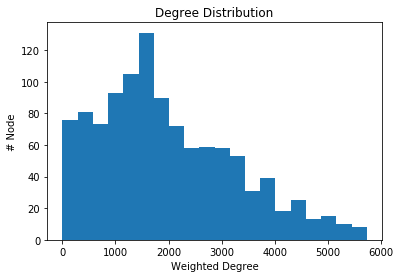

In [17]:
d = M_mac_surface.todense().sum(axis=1)

plt.xlabel("Weighted Degree")
plt.ylabel("# Node")
plt.title("Degree Distribution")
plt.hist(d, bins=20);

**The average degree is below**

In [18]:
d_avg = np.mean(d)
print("The average degree is {:.2f}.".format(d_avg))

The average degree is 1976.72.


**Graph generate models**

Now wegenerate Erdős–Rényi and Barabási-Albert graph using NetworkX and compare with our graph

In [19]:
er = nx.erdos_renyi_graph(node_number, rate)
ba = nx.barabasi_albert_graph(node_number, int(edge_number/node_number))

In [20]:
print('My Erdős–Rényi network has {} nodes.'.format(len(er.nodes())))
print('My Erdős–Rényi network has {} edges.'.format(er.size()))
print('My Barabási-Albert network has {} nodes.'.format(len(ba.nodes())))
print('My Barabási-Albert network has {} edges.'.format(ba.size()))

My Erdős–Rényi network has 1108 nodes.
My Erdős–Rényi network has 268381 edges.
My Barabási-Albert network has 1108 nodes.
My Barabási-Albert network has 209572 edges.


From the generarion model, we can see that the number of edge of our network is more similar to that of Erdős–Rényi model which is a random graph.

In [21]:
giant_G = max(nx.connected_component_subgraphs(G), key=len)
giant_er = max(nx.connected_component_subgraphs(er), key=len)
giant_ba = max(nx.connected_component_subgraphs(ba), key=len)
print(len(giant_G.nodes()))
print(len(giant_er.nodes()))
print(len(giant_ba.nodes()))

1108
1108
1108


All of the graph are fully connected.

In [22]:
print (nx.average_clustering(G))
print (nx.average_clustering(er))
print (nx.average_clustering(ba))

1.0
0.4375934018291465
0.4433276394942439


From the way we construct the graph, we can easily see that the graph is fully connected. Now we proved that. 

And also we can see that the generate models can't mimic the clustering coeffcient of real graph.

### B.  **`Spectral Graph Theory`**

Calculate the **Similarity Matrix** by normalizing the maximum as 1

In [23]:
M_mac_surface.max()

47

In [24]:
S_mac_surface = M_mac_surface.todense()/M_mac_surface.max()
np.fill_diagonal(S_mac_surface ,0)

Keep the **TOP K Neighbors**.

We first use K = 300.

In [25]:
W_mac_surface = S_mac_surface.getA().copy()
NEIGHBORS = 300

# Keep only the K strongest edges
# By making weights of all other edges equal to 0
ind = np.argsort(W_mac_surface)[:,::-1][:,NEIGHBORS:]
for i in range(W_mac_surface.shape[1]):
    W_mac_surface[i][ind[i]]=0
    
# Make it symmestric
bigger = W_mac_surface.transpose() > W_mac_surface
W_mac_surface = W_mac_surface - W_mac_surface*bigger + W_mac_surface.transpose()*bigger

In [26]:
W_mac_surface

array([[ 0.        ,  0.19148936,  0.57446809, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19148936,  0.        ,  0.12765957, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.57446809,  0.12765957,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.21276596],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.21276596,
         0.        ,  0.        ]])

Calculate the **Laplacian**.

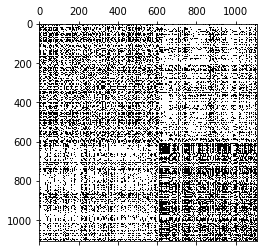

In [27]:
degrees = np.sum(W_mac_surface, axis=0)
D = np.diag(degrees)
D_0_5 = np.diag(1./np.sqrt(degrees))
laplacian = np.dot(D_0_5, np.dot((D - W_mac_surface), D_0_5))
plt.spy(laplacian)
plt.show()

**Eigenvalue decomposition** of the Laplacian.

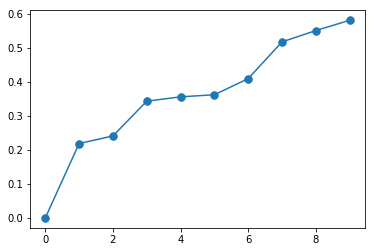

In [28]:
from scipy import sparse, stats, spatial
laplacian = sparse.csr_matrix(laplacian)
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=10, which='SM')
plt.plot(eigenvalues, '.-', markersize=15);

**Plot** the groud truth and the prediction based on spectral graph theory. 

The **ground truth** is **`label_mac_surface`** in which we label 0 for Mac group and 1 for Surface group.

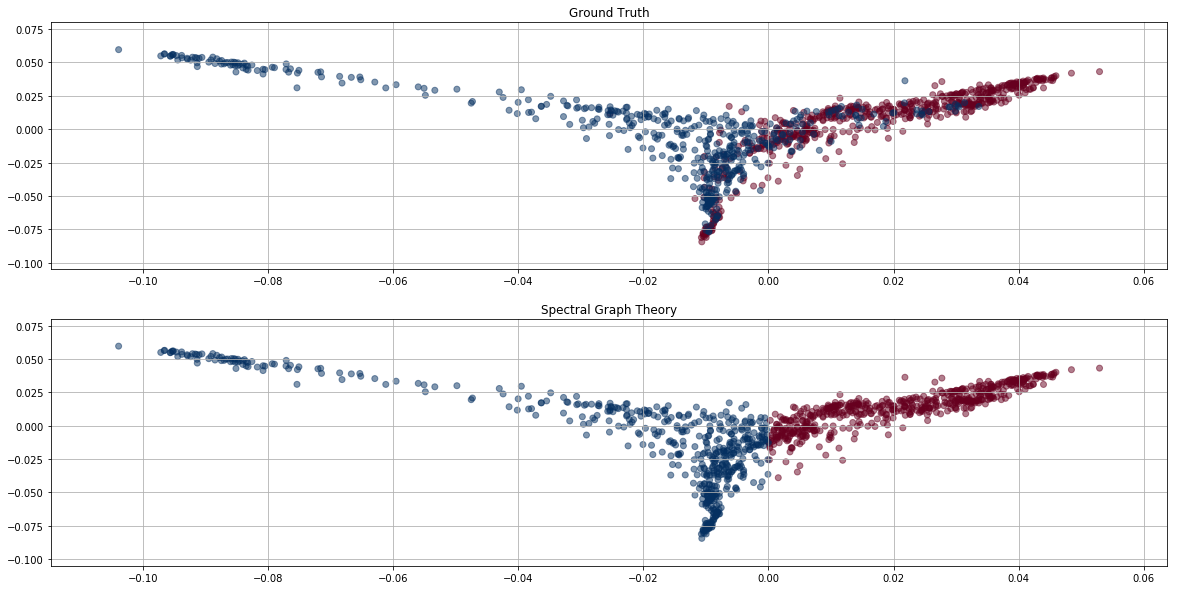

In [32]:
x1 = eigenvectors[:,1]
y1 = eigenvectors[:,2]

fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(x1, y1, c=label_mac_surface, cmap='RdBu', alpha=0.5)
ax[0].set_title('Ground Truth')
ax[0].grid()
ax[1].scatter(x1, y1, c=(x1<0), cmap='RdBu', alpha=0.5)
ax[1].set_title('Spectral Graph Theory')
ax[1].grid()

**Error rate**

In [33]:
error_rate = np.sum((x1<0) != label_mac_surface)/len(label_mac_surface)
print("The error rate of Spectral Graph Theory is {:.2%}".format(error_rate))

The error rate of Spectral Graph Theory is 17.24%


### **`C. Transductive Learning`**

In [34]:
# Ground truth.
x = np.ones(len(G.nodes))
x[0:n_mac] = -1

def prepare_observations(p):
    """Prepare observations, where p is the percentage of values to keep."""
    rs = np.random.RandomState(42)
    M = np.diag(rs.uniform(size=len(G.nodes)) < p)
    return M.dot(x)

# Play with the percentage of observed values.
y = prepare_observations(p=0.1)

In [35]:
def solve(y, alpha):
    """
    Solve the optimization problem.
    
    Parameters:
        y: the observations
        alpha: the balance between fidelity and smoothness prior.
    
    Returns:
        x_pred: the predicted class
        x_star: the solution of the optimization problem
    """
    
    M = np.diag(y!=0)
    
    x_star = np.linalg.solve(M+alpha*laplacian, M.dot(y))
    
    x_pred = np.ones(len(G.nodes))
    x_pred[x_star<0] = -1
    
    return x_pred, x_star

# Try with default setting
x_pred, x_star = solve(y, alpha=1)

# Be sure that the prediction is binary.
np.testing.assert_equal(abs(x_pred), 1)

# Error rate.
err = np.sum(x != x_pred)
print('{} errors ({:.2%})'.format(err, err/len(x)))

342 errors (30.87%)


In [36]:
# Paramete sweeping

alpha = 0.1

for p in [0.1, 0.3, 0.5, 0.7, 0.9]:
    y = prepare_observations(p)
    x_pred, _ = solve(y, alpha)
    err = np.sum(x != x_pred)
    print('p = {}: {:6.2%}'.format(p, err/len(x)))

p = 0.1: 18.68%
p = 0.3:  9.57%
p = 0.5:  7.49%
p = 0.7:  3.79%
p = 0.9:  1.17%


The result of transductive learning is pretty good since it is half-surpervised learning. And only with only 30% of known facts, we can get an error which is less than 10%. And that's very useful in real life problems because we often do not know everything of our dataset and the label information.

**Plot**

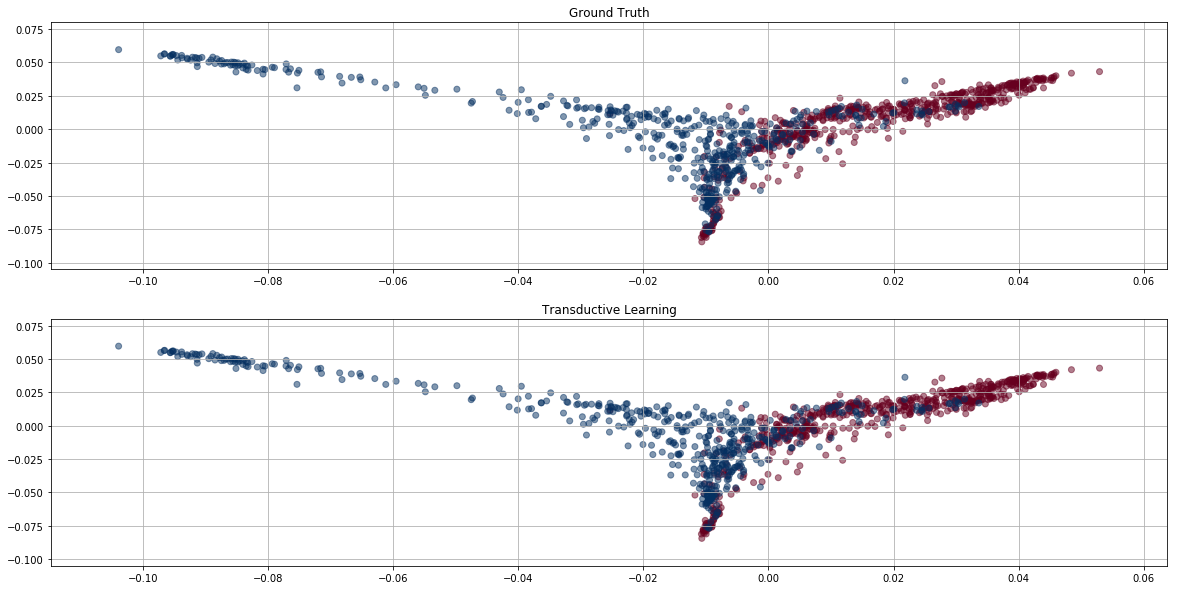

In [37]:
x1 = eigenvectors[:,1]
y1 = eigenvectors[:,2]
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(x1, y1, c=label_mac_surface, cmap='RdBu', alpha=0.5)
ax[0].set_title('Ground Truth')
ax[0].grid()
ax[1].scatter(x1, y1, c=x_pred, cmap='RdBu', alpha=0.5)
ax[1].set_title('Transductive Learning')
ax[1].grid()

### 5.2 Use both the information of 'also_bought' and 'reviewer'

In [38]:
df_review.head()

,reviewerID
asin,
B0083S3NC8,"[A18I2DO90GZCQY, A2C4BO8UURNWNN, A2RF9FHC4HC3J..."
B0047FHOWG,"[A3OTFTP2WVZVQY, A10KIQXOE926FN, A1Q165PZVZS34..."
B0067SJC80,"[A3QLALFN0WGF87, A395EVHF1TAQN0, AOEDXOKYPII2Z..."
B002WQP2IA,"[AN3ILH8NOGNH4, A3FGRP5N72WES1, ADN4437IJDIPP,..."
B006IC4YZQ,"[A3W3PWGZ36249Y, AZLDKR28KT3FB, A3M3DL4G9NS3Z2..."


Select the review information of data in our DataFrame.

In [39]:
df_review_chosen = df_review.loc[df_all.asin].reset_index()

Build the graph as we did above.

In [40]:
GB = nx.Graph()
GB.add_nodes_from(df_all.asin.values)

In [41]:
b_len_list = [] # list for # shared also_bought
r_len_list = [] # list for # shared reviewer

for i in range(len(df_all)):
    for j in range(i+1, len(df_all)):
        b_len_list.append(len(set(df_all.iloc[i]['also_bought'])&set(df_all.iloc[j]['also_bought'])))
        r_len_list.append(len(set(df_review_chosen.iloc[i]['reviewerID'])&set(df_review_chosen.iloc[j]['reviewerID'])))

In [42]:
# Study the basics of two lists
df_b_r = pd.DataFrame({'b': b_len_list, 'r': r_len_list})
# Only show the non-zero value distribution
pd.DataFrame([df_b_r[df_b_r.b>0].describe().b, df_b_r[df_b_r.r>0].describe().r])

,count,mean,std,min,25%,50%,75%,max
b,268866.0,4.073036,4.454166,1.0,1.0,2.0,5.0,47.0
r,47420.0,1.953838,3.370354,1.0,1.0,1.0,2.0,211.0


As the table shown above, the distribution of the number of shared `also_bought` products or shared reviewers are quite skewed. The mean value is slightly below the third quartile which means there are only a few extremely large values in the two list. And, in order to add the two number together, we choose to normalize them a liite bit using the **mean** of all non-zero elements.

In [43]:
b_len_list.reverse()
r_len_list.reverse()
mean_b = np.mean(df_b_r[df_b_r.b>0].b)
mean_r = np.mean(df_b_r[df_b_r.r>0].r)

for i in range(len(df_all)):
    for j in range(i+1, len(df_all)):
        b_len = b_len_list.pop()/mean_b
        r_len = r_len_list.pop()/mean_r
        # The weight is manually chosen now and may need to be modified
        GB.add_edge(df_all.iloc[i]['asin'], df_all.iloc[j]['asin'], weight=0.2*b_len+0.8*r_len)

In [44]:
M_mac_surface_2 = nx.adjacency_matrix(GB,weight='weight')
M_mac_surface_2.todense()

matrix([[ 0.        ,  0.85138126,  1.32579223, ...,  0.        ,
          0.        ,  0.45855393],
        [ 0.85138126,  0.        ,  0.2946205 , ...,  0.        ,
          0.        ,  0.04910342],
        [ 1.32579223,  0.2946205 ,  0.        , ...,  0.        ,
          0.        ,  0.04910342],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.09820683,  0.49103416],
        [ 0.        ,  0.        ,  0.        , ...,  0.09820683,
          0.        ,  0.09820683],
        [ 0.45855393,  0.04910342,  0.04910342, ...,  0.49103416,
          0.09820683,  0.        ]])

### `A. Spectral Graph Theory`

**Similarity Matrix**

In [56]:
M_mac_surface_2.max()

86.394059427313266

In [57]:
S_mac_surface_2 = M_mac_surface_2.todense()/M_mac_surface_2.max()
np.fill_diagonal(S_mac_surface_2,0)

**TOP K Neighbors**

In [58]:
W_mac_surface_2 = S_mac_surface_2.getA().copy()
NEIGHBORS = 300

# Keep only the K strongest edges
# By making weights of all other edges equal to 0
ind = np.argsort(W_mac_surface_2)[:,::-1][:,NEIGHBORS:]
for i in range(W_mac_surface_2.shape[1]):
    W_mac_surface_2[i][ind[i]]=0
    
# Make it symmestric
bigger = W_mac_surface_2.transpose() > W_mac_surface_2
W_mac_surface_2 = W_mac_surface_2 - W_mac_surface_2*bigger + W_mac_surface_2.transpose()*bigger

**Calculate Laplacian**

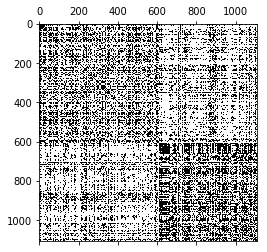

In [59]:
degrees = np.sum(W_mac_surface_2, axis=0)
D = np.diag(degrees)
D_0_5 = np.diag(1./np.sqrt(degrees))
laplacian = np.dot(D_0_5, np.dot((D - W_mac_surface_2), D_0_5))
plt.spy(laplacian)
plt.show()

**Eigenvalue Decomposition**

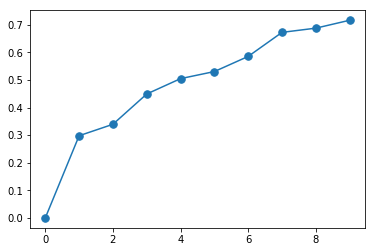

In [60]:
from scipy import sparse, stats, spatial
laplacian = sparse.csr_matrix(laplacian)
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=10, which='SM')
plt.plot(eigenvalues, '.-', markersize=15);

**Plot**

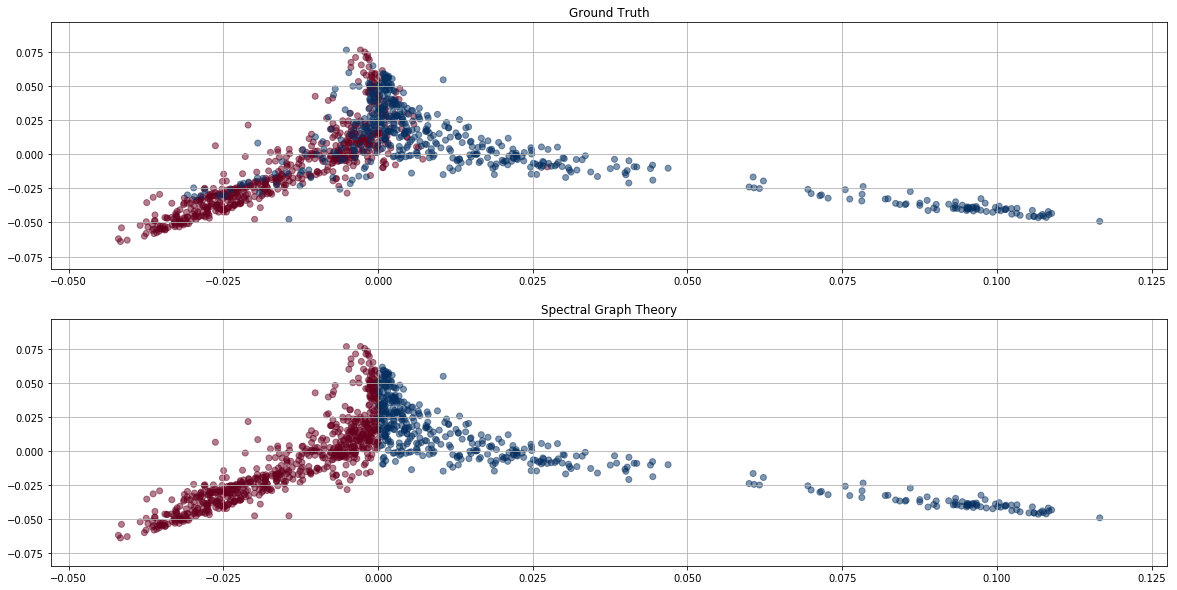

In [62]:
x2 = eigenvectors[:,1]
y2 = eigenvectors[:,2]
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(x2, y2, c=label_mac_surface, cmap='RdBu', alpha=0.5)
ax[0].set_title('Ground Truth')
ax[0].grid()
ax[1].scatter(x2, y2, c=(x2>0), cmap='RdBu', alpha=0.5)
ax[1].set_title('Spectral Graph Theory')
ax[1].grid()

**Error Rate**

In [64]:
error_rate_2 = np.sum((x2>0) != label_mac_surface)/len(label_mac_surface)
print("The error rate of Spectral Graph Theory is {:.2%}".format(error_rate_2))

The error rate of Spectral Graph Theory is 15.61%


With the information of reviewers, the error rate goes down! Now, I try to explain this result. The `also_bought` information is gerenrated by Amazon based on the behaviours of a large number of users which **indirectly** reflects the connection between two products. On the other hand, for the dataset of reviewers, the information of shared reviewers **directly** reflects how often people buy the two products together. So, with the information of reviewers, we get lower error rate.

### `B. Supervised Classification`

In [65]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.25),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

score = []

In [66]:
from sklearn.model_selection import train_test_split
X, y = np.array(M_mac_surface_2.todense()), np.array(label_mac_surface)
# 90% is training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/10)

In [67]:
# iterate over classifiers
# without parameter tuning
for clf in classifiers:
    clf.fit(X_train, y_train)
    score.append(clf.score(X_test, y_test))

/Users/suntao/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


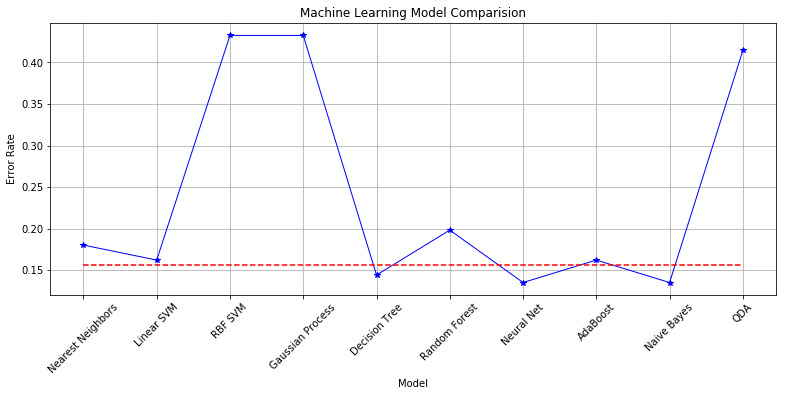

In [68]:
error = np.ones(np.shape(score))-score

plt.figure(figsize=(13,5))      
plt.xlabel("Model") 
plt.ylabel("Error Rate")  
plt.title("Machine Learning Model Comparision") 
plt.grid()
plt.xticks(range(len(error)), names, rotation=45)
plt.plot(range(len(error)), error, "b*-", linewidth=1)
plt.plot(range(len(error)), [error_rate_2]*len(error), "r--", linewidth=1.5);

Now we can see that different machine learning models vary a lot in this problem. 

We can see clearly the difference between machine learning models and spectral graph theroy models. As we implement before, the error rate of our spectral graph model is liitle above 15% which beats several machine learning models **without further parameter tuning**.

---

### 5.3 Network Graphs for Mackbook and surface related products comparison

- Our data preparation notebook for generating network graphs can be accessed with the following link:

https://nbviewer.jupyter.org/gist/xiangzhemeng/deb2495e7f9af7953d69859216aee7b8

- Our network graph is shown in this page:

https://xiangzhemeng.github.io/ntds/index.html

---
## Study on Macbook, Surface and ThinkPad

Load the data.

In [69]:
df_product = pd.read_pickle('data/product_also_bought.pkl')
df_review = pd.read_pickle('data/review_also_bought.pkl')

### 6.0 Build three data groups

Find the `also_bought` products of list of products.

In [70]:
def get_all_related_asin_from_list_asin(list_asin):
    res = []
    for asin in list_asin:
        res.extend(df_product.loc[asin]['also_bought'])
    res = list(set(res))
    return res

In [71]:
# Macbook
nb_layer = 2
df_mac = df_product[df_product.index == 'B005CWJB5G']
list_asin = ['B005CWJB5G']
for i in range(nb_layer):
    index = get_all_related_asin_from_list_asin(list_asin)
    df_mac = pd.concat([df_mac,df_product.loc[index]])
    list_asin = index
df_mac = df_mac.reset_index().drop_duplicates(subset='asin')
print('We have {} products in the group of mac.'.format(df_mac.shape[0]))

We have 743 products in the group of mac.


In [72]:
# Surface
nb_layer = 2
df_surface = df_product[df_product.index == 'B00FG7MVJU']
list_asin = ['B00FG7MVJU']
for i in range(nb_layer):
    index = get_all_related_asin_from_list_asin(list_asin)
    df_surface = pd.concat([df_surface,df_product.loc[index]])
    list_asin = index
df_surface = df_surface.reset_index().drop_duplicates(subset='asin')
print('We have {} products in the group of surface.'.format(df_surface.shape[0]))

We have 499 products in the group of surface.


In [73]:
# ThinkPad
nb_layer = 2
df_think = df_product[df_product.index == 'B00JP7OGQ8']
list_asin = ['B00JP7OGQ8']
for i in range(nb_layer):
    index = get_all_related_asin_from_list_asin(list_asin)
    df_think = pd.concat([df_think,df_product.loc[index]])
    list_asin = index
df_think = df_think.reset_index().drop_duplicates(subset='asin')
print('We have {} products in the group of ThinkPad.'.format(df_think.shape[0]))

We have 574 products in the group of ThinkPad.


In [74]:
# FORMER CODE
# Find the duplicated products among three groups.

dupasin_mac_surface = list(set(df_mac.asin.values) & set(df_surface.asin.values))
print('We have {} duplicate products in Mac and Surface.'.format(len(dupasin_mac_surface)))
dupasin_mac_think = list(set(df_mac.asin.values) & set(df_think.asin.values))
print('We have {} duplicate products in Mac and ThinkPad.'.format(len(dupasin_mac_think)))
dupasin_think_surface = list(set(df_think.asin.values) & set(df_surface.asin.values))
print('We have {} duplicate products in ThinkPad and Surface.'.format(len(dupasin_think_surface)))

dupasin = list(set(df_think.asin.values) & set(df_surface.asin.values) & set(df_mac.asin.values))
print('We have {} duplicate products.'.format(len(dupasin)))

We have 134 duplicate products in Mac and Surface.
We have 148 duplicate products in Mac and ThinkPad.
We have 141 duplicate products in ThinkPad and Surface.
We have 80 duplicate products.


In [75]:
df_think_surface = pd.concat([df_think.reset_index(), df_surface])
df_think_mac = pd.concat([df_think.reset_index(), df_mac])
df_mac_surface = pd.concat([df_mac.reset_index(), df_surface])

# distinct mac products
mac_duplicate = list(set(df_mac.asin.values) & set(df_think_surface.asin.values))
print('We have {} distinct products for Macbook.'.format(len(df_mac)-len(mac_duplicate)))
# distinct surface products
surface_duplicate = list(set(df_surface.asin.values) & set(df_think_mac.asin.values))
print('We have {} distinct products for Surface.'.format(len(df_surface)-len(surface_duplicate)))
# distincy thinkpad products
think_duplicate = list(set(df_think.asin.values) & set(df_mac_surface.asin.values))
print('We have {} distinct products for Thinkpad.'.format(len(df_think)-len(think_duplicate)))

We have 541 distinct products for Macbook.
We have 304 distinct products for Surface.
We have 365 distinct products for Thinkpad.


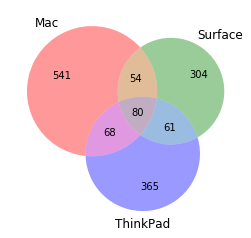

In [76]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
v=venn3(subsets = (541, 304, 54, 365, 68, 61, 80), set_labels = ('Mac', 'Surface', 'ThinkPad'))
plt.show()

We **only** keep products distinct to one of the groups.

In [77]:
df_think_new = df_think[~df_think['asin'].isin(think_duplicate)]
df_mac_new = df_mac[~df_mac['asin'].isin(mac_duplicate)]
df_surface_new = df_surface[~df_surface['asin'].isin(surface_duplicate)]

In [78]:
df_all_new = pd.concat([df_think_new.reset_index(), df_mac_new, df_surface_new])
print('We have {} products in all.'.format(df_all_new.shape[0]))

We have 1210 products in all.


In [79]:
df_all_new.head()

,also_bought,asin,index
0,"[B002HZW7D4, B00DBV28TG, B002J9HBIO, B005QXX0M...",B00JP7OGQ8,0.0
1,"[B007EJ25Y4, B00KMRGF28, B00JP7OGQ8, B00F4MEK6...",B005IPKVNS,1.0
2,"[B00BIULEJC, B00G5T8DJ0, B005SB786U, B00K2O4TI...",B001DHECXA,5.0
3,"[B00DDFESKC, B00D78PZE8, B005QXX0MG, B007ABANF...",B007AB92DI,7.0
4,"[B004AM624C, B006NNWZSI, B003RG13FK, B003NR57B...",B003WU6KFO,8.0


### Build the graph
Same as before, we use the data we selected above (in df_all_new) to build the product graph.

- **Node**: Product


- **Weight of Edge**: We implement two ways to calculate the weight of edge.

    - Use only the information of 'also_bougtht': $$Weight = \# Shared\_Neighbors$$
    
    - Use both the information of 'also_bougtht' and 'reviewer':$$Weight = 0.2 * \frac{\# Shared\_Neighbors}{Average\_Shared\_Neighbors} + 0.8 * \frac{\# Shared\_Reviewers}{Average\_Shared\_Reviewers}$$
    where $Average$ is the mean of **non-zero** elements not of all elements.
    
   
    
- **Similarity**: For the implementation of spectral graph theory, we also need define the similarity between two products. The similarity is calculated as below:


$$Similarity = \frac{Weight}{Max\_Weight}$$

### 6.1 Use only the information of 'also_bought'

In [80]:
G = nx.Graph()
G.add_nodes_from(df_all_new.asin.values)

In [81]:
for i in range(len(df_all_new)):
    for j in range(i+1, len(df_all_new)):
        set_len = len(set(df_all_new.iloc[i]['also_bought'])&set(df_all_new.iloc[j]['also_bought']))
        G.add_edge(df_all_new.iloc[i]['asin'], df_all_new.iloc[j]['asin'], weight=set_len)

In [82]:
A = nx.adjacency_matrix(G, weight='weight')
A.todense()

matrix([[ 0,  1,  3, ...,  1,  0,  0],
        [ 1,  0,  4, ...,  0,  0,  0],
        [ 3,  4,  0, ...,  1,  1,  2],
        ..., 
        [ 1,  0,  1, ...,  0,  2, 10],
        [ 0,  0,  1, ...,  2,  0,  2],
        [ 0,  0,  2, ..., 10,  2,  0]], dtype=int64)

### **`A. Spectral Graph Theory`**

Calculate the **Similarity Matrix** by normalizing the maximum as 1

In [300]:
A.max()

47

In [301]:
similar = A.todense()/A.max()
np.fill_diagonal(similar,0)

Keep the **TOP K Neighbors**.

We first use K = 300.

In [302]:
weights = similar.getA().copy()
NEIGHBORS = 300

# Keep only the K strongest edges
# By making weights of all other edges equal to 0
ind = np.argsort(weights)[:,::-1][:,NEIGHBORS:]
for i in range(weights.shape[1]):
    weights[i][ind[i]]=0
    
# Make it symmestric
bigger = weights.transpose() > weights
weights = weights - weights*bigger + weights.transpose()*bigger

In [303]:
weights

array([[ 0.        ,  0.0212766 ,  0.06382979, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0212766 ,  0.        ,  0.08510638, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06382979,  0.08510638,  0.        , ...,  0.        ,
         0.        ,  0.04255319],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.21276596],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.04255319],
       [ 0.        ,  0.        ,  0.04255319, ...,  0.21276596,
         0.04255319,  0.        ]])

Calculate the **Laplacian**.

In [304]:
degrees = np.sum(weights, axis=0)+0.0001
D = np.diag(degrees)
D_0_5 = np.diag(1./np.sqrt(degrees))
laplacian = np.dot(D_0_5, np.dot((D - weights), D_0_5))

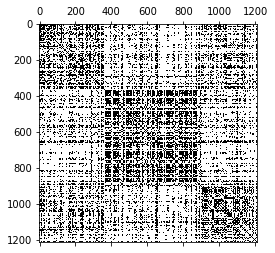

In [305]:
plt.spy(laplacian)
plt.show()

**Eigenvalue decomposition** of the Laplacian.

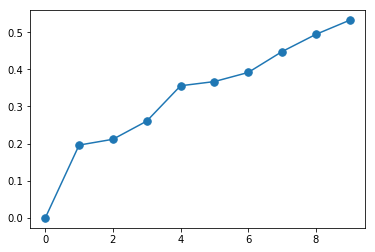

In [306]:
from scipy import sparse, stats, spatial
laplacian = sparse.csr_matrix(laplacian)
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=10, which='SM')
plt.plot(eigenvalues, '.-', markersize=15);

**Ground truth**: we label all of data in think_pad group as 0, surface group as 1 and mac group as 2.

In [307]:
labels = np.ones(A.shape[0])
labels[0:len(df_think_new)] = 0
labels[len(df_think_new):len(df_think_new)+len(df_mac_new)] = 1
labels[len(df_think_new)+len(df_mac_new):len(df_think_new)+len(df_mac_new)+len(df_surface_new)] = 2

**Plot** the groud truth and the prediction based on spectral graph theory.

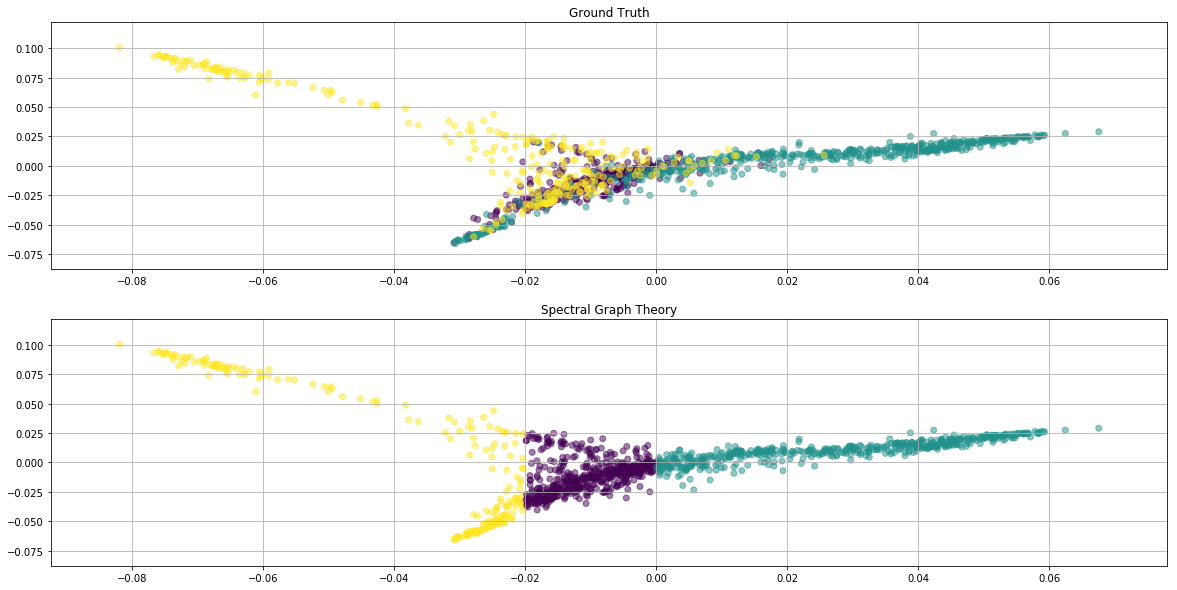

In [310]:
x1 = eigenvectors[:,1]
y1 = eigenvectors[:,2]

colorList = list()
for i in x1:
    if i < -.02:
        colorList.append(2)
    elif i > 0:
        colorList.append(1)
    else:
        colorList.append(0)
        
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(x1, y1, c=labels, alpha=0.5)
ax[0].set_title('Ground Truth')
ax[0].grid()
ax[1].scatter(x1, y1, c=colorList, alpha=0.5)
ax[1].set_title('Spectral Graph Theory')
ax[1].grid()

**Error rate**

In [311]:
error_rate = np.sum(colorList != labels)/len(labels)
print("The error rate of Spectral Graph Theory is {:.2%}".format(error_rate))

The error rate of Spectral Graph Theory is 29.50%


### **`B. Transductive Learning`**

In [281]:
# Ground truth.
x = np.ones(len(G.nodes))
x[0:len(df_think_new)] = -1
x[len(df_think_new):len(df_think_new)+len(df_mac_new)] = 1
x[len(df_think_new)+len(df_mac_new):len(df_think_new)+len(df_mac_new)+len(df_surface_new)] = 3

# x[0:n_mac] = -1

def prepare_observations(p):
    """Prepare observations, where p is the percentage of values to keep."""
    rs = np.random.RandomState(42)
    M = np.diag(rs.uniform(size=len(G.nodes)) < p)
    return M.dot(x)

# Play with the percentage of observed values.
y = prepare_observations(p=0.1)

In [282]:
def solve(y, alpha):
    """
    Solve the optimization problem.
    
    Parameters:
        y: the observations
        alpha: the balance between fidelity and smoothness prior.
    
    Returns:
        x_pred: the predicted class
        x_star: the solution of the optimization problem
    """
    
    M = np.diag(y!=0)
    
    x_star = np.linalg.solve(M+alpha*laplacian, M.dot(y))
    
    x_pred = np.ones(len(G.nodes))
    for i in range(len(x_star)):
        if x_star[i] < 0:
            x_pred[i] = -1
        elif x_star[i] > 0 and x_star[i] < 2:
            x_pred[i] = 1
        else:
            x_pred[i] = 3
    
    return x_pred, x_star

x_pred, x_star = solve(y, alpha=1)

# Error rate.
err = np.sum(x != x_pred)
print('{} errors ({:.2%})'.format(err, err/len(G.nodes)))

621 errors (51.32%)


In [283]:
alpha = 0.1

for p in [0.1, 0.3, 0.5, 0.7, 0.9]:
    y = prepare_observations(p)
    x_pred, _ = solve(y, alpha)
    err = np.sum(x != x_pred)
    print('{}: {:6.2%}'.format(p, err/len(G.nodes)))

0.1: 49.09%
0.3: 33.88%
0.5: 24.46%
0.7: 13.97%
0.9:  4.71%


**Plot**

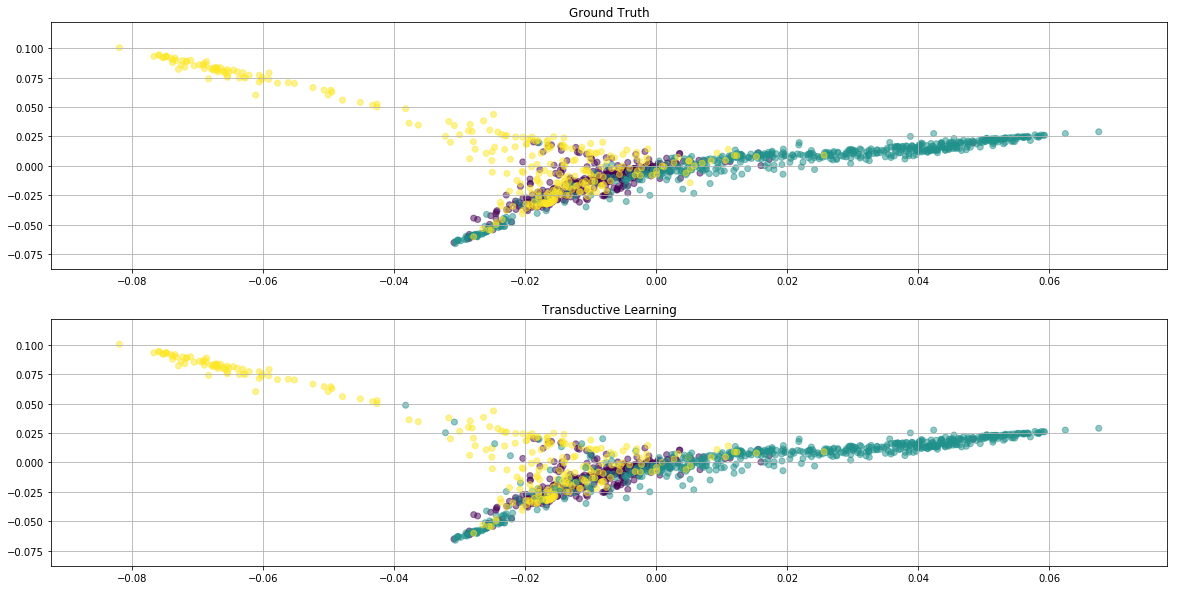

In [284]:
x1 = eigenvectors[:,1]
y1 = eigenvectors[:,2]
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(x1, y1, c=labels, alpha=0.5)
ax[0].set_title('Ground Truth')
ax[0].grid()
ax[1].scatter(x1, y1, c=x_pred, alpha=0.5)
ax[1].set_title('Transductive Learning')
ax[1].grid()

### 6.2 Use both the information of 'also_bought' and 'reviewer'

In [218]:
df_review.head()

,reviewerID
asin,
B0083S3NC8,"[A18I2DO90GZCQY, A2C4BO8UURNWNN, A2RF9FHC4HC3J..."
B0047FHOWG,"[A3OTFTP2WVZVQY, A10KIQXOE926FN, A1Q165PZVZS34..."
B0067SJC80,"[A3QLALFN0WGF87, A395EVHF1TAQN0, AOEDXOKYPII2Z..."
B002WQP2IA,"[AN3ILH8NOGNH4, A3FGRP5N72WES1, ADN4437IJDIPP,..."
B006IC4YZQ,"[A3W3PWGZ36249Y, AZLDKR28KT3FB, A3M3DL4G9NS3Z2..."


Select the review information of data in our DataFrame.

In [219]:
df_review_chosen = df_review.loc[df_all_new.asin].reset_index()

Build the graph as we did above.

In [220]:
GB = nx.Graph()
GB.add_nodes_from(df_all_new.asin.values)
b_len_list = [] # list for # shared also_bought
r_len_list = [] # list for # shared reviewer

for i in range(len(df_all_new)):
    for j in range(i+1, len(df_all_new)):
        b_len_list.append(len(set(df_all_new.iloc[i]['also_bought'])&set(df_all_new.iloc[j]['also_bought'])))
        r_len_list.append(len(set(df_review_chosen.iloc[i]['reviewerID'])&set(df_review_chosen.iloc[j]['reviewerID'])))

In [221]:
# Study the basics of two lists
df_b_r = pd.DataFrame({'b': b_len_list, 'r': r_len_list})
pd.DataFrame([df_b_r[df_b_r.b>0].describe().b, df_b_r[df_b_r.r>0].describe().r])

,count,mean,std,min,25%,50%,75%,max
b,263493.0,3.520644,3.996601,1.0,1.0,2.0,4.0,47.0
r,41234.0,1.660305,2.198098,1.0,1.0,1.0,2.0,116.0


Just as above, we get two skewed distribution here.

In [222]:
b_len_list.reverse()
r_len_list.reverse()
mean_b = np.mean(df_b_r[df_b_r.b>0].b)
mean_r = np.mean(df_b_r[df_b_r.r>0].r)

for i in range(len(df_all_new)):
    for j in range(i+1, len(df_all_new)):
        b_len = b_len_list.pop()/mean_b
        r_len = r_len_list.pop()/mean_r
        GB.add_edge(df_all_new.iloc[i]['asin'], df_all_new.iloc[j]['asin'], weight=0.2*b_len+0.8*r_len)

In [223]:
B = nx.adjacency_matrix(GB, weight='weight')
B.todense()

matrix([[ 0.        ,  0.05680779,  0.17042337, ...,  0.05680779,
          0.        ,  0.        ],
        [ 0.05680779,  0.        ,  0.22723117, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.17042337,  0.22723117,  0.        , ...,  0.05680779,
          0.05680779,  0.11361558],
        ..., 
        [ 0.05680779,  0.        ,  0.05680779, ...,  0.        ,
          0.11361558,  0.56807792],
        [ 0.        ,  0.        ,  0.05680779, ...,  0.11361558,
          0.        ,  0.11361558],
        [ 0.        ,  0.        ,  0.11361558, ...,  0.56807792,
          0.11361558,  0.        ]])

### `A. Spectral Graph Theory`

**Similarity Matrix**

In [224]:
B.max()

56.177397220397381

In [225]:
similarB = B.todense()/B.max()
np.fill_diagonal(similarB, 0)

**TOP K Neighbors**

In [285]:
weights = similarB.getA().copy()
NEIGHBORS = 300

# Keep only the K strongest edges
# By making weights of all other edges equal to 0
ind = np.argsort(weights)[:,::-1][:,NEIGHBORS:]
for i in range(weights.shape[1]):
    weights[i][ind[i]] = 0
    
# Make it symmestric
bigger = weights.transpose() > weights
weights = weights - weights*bigger + weights.transpose()*bigger

**Calculate Laplacian**

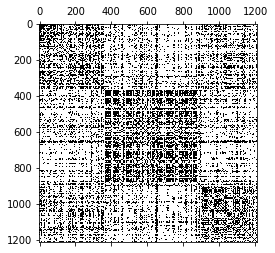

In [286]:
degrees = np.sum(weights, axis=0)
D = np.diag(degrees)
D_0_5 = np.diag(1./np.sqrt(degrees))
laplacian = np.dot(D_0_5, np.dot((D - weights), D_0_5))
plt.spy(laplacian)
plt.show()

**Eigenvalue Decomposition**

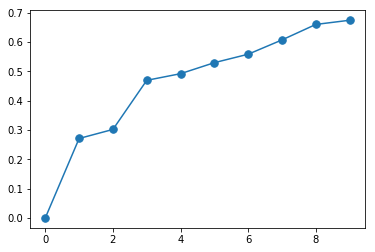

In [287]:
from scipy import sparse, stats, spatial
laplacian = sparse.csr_matrix(laplacian)
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=10, which='SM')
plt.plot(eigenvalues, '.-', markersize=15);

**Plot**

In [288]:
labels = np.ones(B.shape[0])
labels[0:len(df_think_new)] = 0
labels[len(df_think_new):len(df_think_new)+len(df_mac_new)] = 1
labels[len(df_think_new)+len(df_mac_new):len(df_think_new)+len(df_mac_new)+len(df_surface_new)] = 2

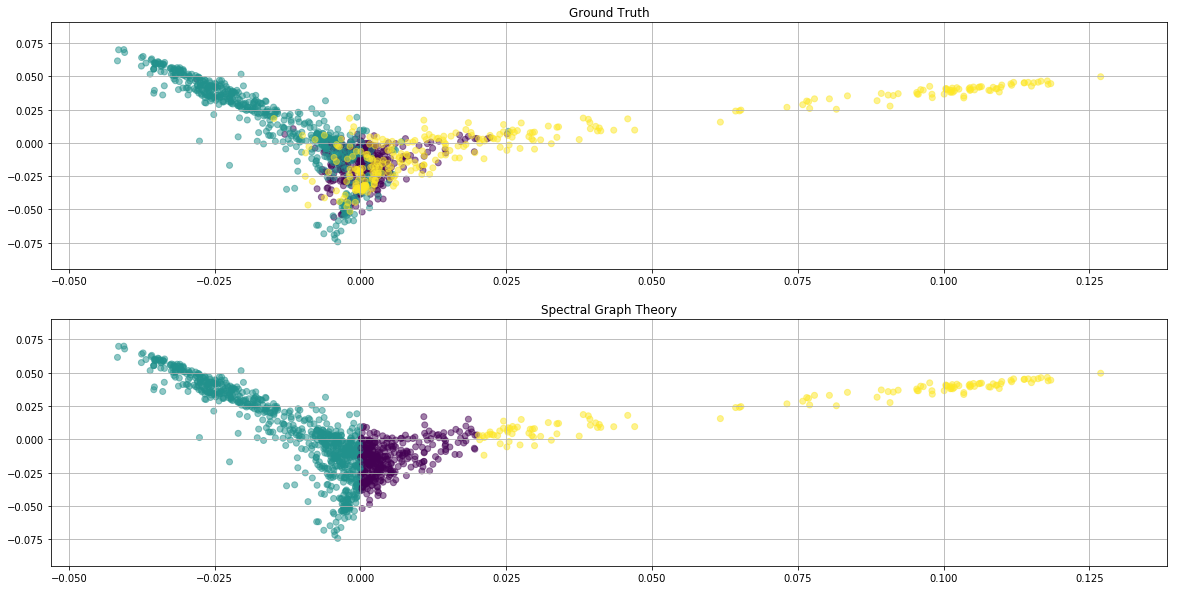

In [295]:
x2 = eigenvectors[:,1]
y2 = eigenvectors[:,2]

colorList = list()
for i in x2:
    if i > 0.02:
        colorList.append(2)
    elif i < 0:
        colorList.append(1)
    else:
        colorList.append(0)

fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(x2, y2, c=labels, alpha=0.5)
ax[0].set_title('Ground Truth')
ax[0].grid()
ax[1].scatter(x2, y2, c=colorList, alpha=0.5)
ax[1].set_title('Spectral Graph Theory')
ax[1].grid()

**Error Rate**

In [296]:
error_rate = np.sum(colorList != labels)/len(labels)
print("The error rate of Spectral Graph Theory is {:.2%}".format(error_rate))

The error rate of Spectral Graph Theory is 31.74%


However, in this case, the information of reviewers doesn't offer any help.

### `B. Supervised Classification`

In [297]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.25),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

score = []

In [298]:
X, y = np.array(B.todense()), np.array(labels)
# 90% is training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/10)


# iterate over classifiers
# without parameter tuning
for clf in classifiers:
    clf.fit(X_train, y_train)
    score.append(clf.score(X_test, y_test))

/Users/suntao/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


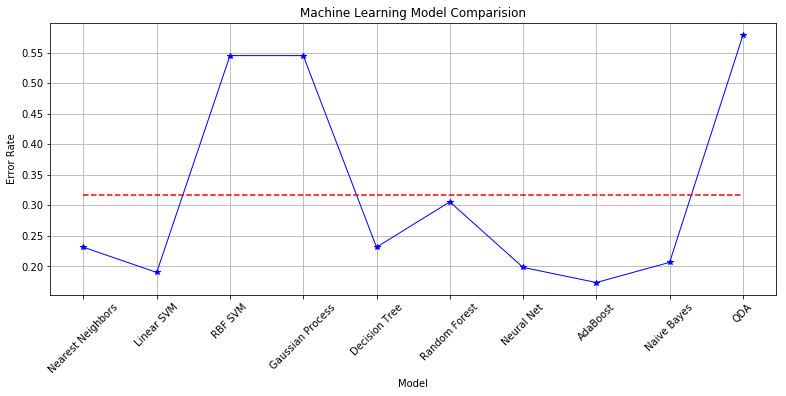

In [299]:
error = np.ones(np.shape(score))-score

plt.figure(figsize=(13,5))      
plt.xlabel("Model") 
plt.ylabel("Error Rate")  
plt.title("Machine Learning Model Comparision") 
plt.grid()
plt.xticks(range(len(error)), names, rotation=45)
plt.plot(range(len(error)), error, "b*-", linewidth=1)

# Use one red line to denote the error rate of spectral graph theory
plt.plot(range(len(error)), [error_rate]*len(error), "r--", linewidth=1.5);

Most of the raw machine learning models are quite good. AdaBoost, Neural Net and Linear SVM are the top three model in this case.

## Conclusion

As shown above, with different definition of weight, we analyze both the graph of two groups and the graph of three groups of data points. 

In the two-group graph, the Spectral Graph Theory performs quite good and it beats several "raw" machine learning models. And the dataset of reviewers helps a lot, which, in our opinion, results from that the information of reviewers directly reflects the connection of two products. And the information of `also_bought` products is a combination of behaviours of many users and maybe some learning algorithm which maybe very useful in real life but is not that direct and obvious connection between products.

In the three-group graph, the Spectral Graph Theory also does a good job. And we can see from the results above that we can cluster three groups with machine learning algorithm and also spectral graph theory with smiliar result. However, in this case, the error rate becomes larger than that of two-group graph. In our opinion, this may results from the way we generate our network. Because the dataset is not that big and we add two layers from manually chosen cores, so the connection between each group of data may also be large and the clusters may not be that obvious. How to label our datapoints right and meaningful becomes another problem now.